# Functions

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order and color
celltype_colors = {
    'Stromal': '#000',  
    'CD31.stromal': '#000',  
    
    'Can.Basal': '#000',  
    'Can.Proliferative': '#000',  
    'Can.EMT': '#000',  
    'Can.Immunogenic': '#000',  
    
    'CD8.T.cells': '#000',  
    'CD4.T.cells': '#000',  
    'T.regs': '#000', 
    
    'CD11c.MY': '#000',
    'CD15.MY': '#000',
    'CD207.MY': '#000', 
    'Other.MY': '#000',   
    
    'CD163.MP': '#000',
    'CD68.MP': '#000',
    'B.cells': '#000',
    
    'Other.immune': '#000',
    'Other': '#000'
}

sns.set_context("paper", font_scale=2)

# 1) Function to plot fold change of median proportion between RCN9 and RCN10
def plot_foldchnage_scatter(counts, ordered_celltypes, filename, size = (7, 8)):
    
    """
    Plots fold change of median proportion between RCN9 and RCN10 for different cell types.
    
    Parameters:
        counts (pd.DataFrame): A dataframe containing cell type counts and their corresponding proportions.
        ordered_celltypes (list): List of cell types in the desired order.
        filename (str): Path where the plot will be saved.
        size (tuple): Size of the plot (default is (7, 8)).
    """
    
    # Initialize empty DataFrames to store results
    rcn9to10_df = pd.DataFrame(columns=['CellType', 'FoldChange', '-Log10Pvalue'])
    rcn10to9_df = pd.DataFrame(columns=['CellType', 'FoldChange', '-Log10Pvalue'])

    for celltype in counts['GlobalCellType'].unique():
        
        # Extract data for the cell type
        cell_df = counts[counts['GlobalCellType']==celltype]
        
        # Separate data for RCN9 and RCN10
        rcn9_df = cell_df[cell_df['rcn_id']=='RCN09']
        rcn10_df = cell_df[cell_df['rcn_id']=='RCN10']
        
        rcn9_values = rcn9_df['proportion'].values
        rcn10_values = rcn10_df['proportion'].values
        
        # Perform Mann-Whitney U-test
        u_stat, p_value = stats.mannwhitneyu(rcn9_values, rcn10_values)
        #print("Mann whitney U test: ", u_stat, "P-value", p_value)
        
        # Add the results to the result_df
        rcn9to10_df = rcn9to10_df.append({'CellType': celltype, 'FoldChange':np.median(rcn9_values)/np.median(rcn10_values), '-Log10Pvalue': -np.log10(p_value)},
                                        ignore_index=True)

        rcn10to9_df = rcn10to9_df.append({'CellType': celltype, 'FoldChange':np.log2(np.median(rcn10_values)/np.median(rcn9_values)), '-Log10Pvalue': -np.log10(p_value)},
                                        ignore_index=True)

    # Set the CellType column as a categorical type with the defined order
    rcn10to9_df['CellType'] = pd.Categorical(rcn10to9_df['CellType'], categories=ordered_celltypes, ordered=True)

    # Sort the DataFrame based on the CellType column
    rcn10to9_df = rcn10to9_df.sort_values('CellType')
    print(rcn10to9_df)
    
    #sns.set(style='white')
    plt.figure(figsize=size)

    # Scatter plot with dynamic dot size and color
    sns.scatterplot(x=rcn10to9_df['FoldChange'],
                    y=rcn10to9_df['CellType'], 
                    size=rcn10to9_df['-Log10Pvalue'],
                    sizes=(40, 200),
                    legend=True, 
                    edgecolor='#363732', 
                    #hue = result_df['Category'],
                    facecolor = '#363732',
                    linewidth = 3)

    # Add reference line at 1 (fold change)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)

    # Customize plot labels and title
    plt.xlabel('Log2(Fold Change)')
    plt.ylabel('GlobalCellType')
    plt.title('Dot Plot of Fold Change of Median Proportions')

    # Remove the top and right spines (the black frame)
    sns.despine(left=True, bottom=False, right=True, top=True)

    # Adjust layout
    plt.tight_layout()
    plt.savefig(filename) 
    plt.show()
        
# 2) Function to plot fold change between PDS and IDC RCN median proportions
def plot_foldchange_inIDSandPDS(df_grouped, filename):
    
    """
    Plots the fold change of median proportions between PDS and IDS for each RCN ID.
    The plot visualizes whether RCNs are enriched in IDS or PDS based on the fold change.

    Parameters:
        df_grouped (pd.DataFrame): A dataframe containing the RCNs, therapy sequence ('IDS' or 'PDS'),
                                and corresponding proportions for each RCN.
        filename (str): The file path where the resulting plot will be saved.
    """
    
    # Calculate fold change of medians between PDS and IDS for each rcn_id
    fold_changes = []
    for rcn_id in df_grouped['rcn_id'].unique():
        
        # Define PDS and IDS proportion values
        pds_values = df_grouped[(df_grouped['rcn_id'] == rcn_id) & (df_grouped['therapy_sequence'] == 'PDS')]['proportion'].values 
        ids_values = df_grouped[(df_grouped['rcn_id'] == rcn_id) & (df_grouped['therapy_sequence'] == 'IDS')]['proportion'].values 
        
        # Calculate median proportion for PDS and IDS
        pds_median = np.median(pds_values)
        ids_median = np.median(ids_values)
        
        # Perform Mann-Whitney U-test
        u_stat, p_value = stats.mannwhitneyu(ids_values,pds_values)
        print("Mann whitney U test: ", u_stat, "P-value", p_value)
        
        # Calculate fold change (handle division by zero)
        fold_change = ids_median/pds_median  if pds_median != 0 else np.nan
        
        # Record results
        fold_changes.append({'rcn_id': rcn_id, 'fold_change': fold_change, 'p_value':p_value})

    # Convert results to a DataFrame
    fc_df = pd.DataFrame(fold_changes)

    # Prepare data for visualization
    fc_df['enriched_in'] = np.where(fc_df['fold_change'] > 1, 'IDS', 'PDS')
    fc_df['log2_fold_change'] = np.log2(fc_df['fold_change'].replace(0, np.nan))  # Log2 transformation
    # fc_df['abs_log2_fold_change'] = fc_df['log2_fold_change'].abs()
    # fc_df_sorted = fc_df.sort_values('abs_log2_fold_change', ascending=False)

    fc_df['colorcategories'] = np.where(
        fc_df['p_value'] > 0.05, 'p>0.05', 
        np.where(fc_df['enriched_in'] == 'IDS', 'IDS', 'PDS')
    )

    # Set seaborn style and plot
    #sns.set(style='whitegrid')
    plt.figure(figsize=(4, 7))
    sns.barplot(
        data=fc_df,
        y='rcn_id',
        x='log2_fold_change',
        hue='colorcategories',
        palette=['#d97d7d','#D9DEE4','#C5DEF7'],
        dodge=False
    )

    # Remove the top and right spines (the black frame)
    sns.despine(left=False, bottom=True, right=True, top=True)

    # Adding a central vertical line to separate the groups
    plt.axvline(0, color='gray', linestyle='--')

    # Labels and aesthetics
    plt.xlabel('Log2 Fold Change (IDS vs PDS)')
    plt.ylabel('')
    
    # Define the custom tick labels
    tick_labels = [-4, -2, 0, 1, 2]
    # Set the custom x-axis ticks
    plt.xticks(tick_labels)
    
    plt.title('Enrichment of RCNs in IDS vs PDS')
    plt.legend(title='Enriched in', loc='upper left')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename) 
    plt.show()


# Prepare the dataset

### Read RCN data: each cell has RCN id

In [2]:
# Read dataframe
RCNs_df = pd.read_csv('/Volumes/h345/afarkkilab/Projects/NKI/Tables/ALL_cells-RNCid_v20241122.csv')
RCNs_df.head(5)

,imageid,CellId,X_position,Y_position,GlobalCellType,cycif.slide,cycif.core.id,rcn_id
0,TMA_18_810_core1,TMA_18_810_core1_c1,1078.500000,271.344828,Stromal,TMA_18_810,core1,RCN01
1,TMA_18_810_core1,TMA_18_810_core1_c2,1050.669014,274.873239,Stromal,TMA_18_810,core1,RCN01
2,TMA_18_810_core1,TMA_18_810_core1_c3,964.737828,280.842697,Can.EMT,TMA_18_810,core1,RCN09
3,TMA_18_810_core1,TMA_18_810_core1_c4,1036.420290,283.555556,Stromal,TMA_18_810,core1,RCN01
4,TMA_18_810_core1,TMA_18_810_core1_c5,1078.121495,282.752336,Stromal,TMA_18_810,core1,RCN01


### Add clinical data

In [3]:
# Load the text file into a pandas DataFrame
slides_explanations = pd.read_csv('/Volumes/h345/afarkkilab/Projects/NKI/Clinical_data/All-slides_cycif2samples.txt', sep="	")
# slides_explanations['imageid'] = slides_explanations['cycif.slide'] + '_' + slides_explanations['cycif.core.id']
# slides_explanations.head(5)

# Merge the two data frames on the slide number and core id columns
combined_dataset = pd.merge(RCNs_df, slides_explanations[["cycif.slide","cycif.core.id","patient"]], on=["cycif.slide","cycif.core.id"])
# combined_dataset.head(5)

# Load molecular profile 2
molecular_profiles = pd.read_csv("/Volumes/h345/afarkkilab/Projects/NKI/Tables/Molecular_profiles_patients_20231123.csv")
# molecular_profiles.head(5)
# Prepare therapy sequence
molecular_profiles['therapy_sequence'] = molecular_profiles['therapy_sequence'].replace(to_replace='NACT', value='IDS', regex=True)
molecular_profiles['therapy_sequence'] = molecular_profiles['therapy_sequence'].replace(to_replace='IDS followed by re-debulking', value='IDS', regex=True)
molecular_profiles['therapy_sequence'] = molecular_profiles['therapy_sequence'].replace(to_replace='PDS followed by IDS', value='IDS', regex=True)
molecular_profiles['therapy_sequence'] = molecular_profiles['therapy_sequence'].replace(['Primairy debulking', 'Only debulking'], 'PDS')
    
# Merge the two data frames on patient column
RCNs_df = pd.merge(combined_dataset, molecular_profiles, on=["patient"])
RCNs_df.head(5)

,imageid,CellId,X_position,Y_position,GlobalCellType,cycif.slide,cycif.core.id,rcn_id,patient,Molecular.profile2,therapy_sequence
0,TMA_18_810_core1,TMA_18_810_core1_c1,1078.500000,271.344828,Stromal,TMA_18_810,core1,RCN01,T12-05811,Other,PDS
1,TMA_18_810_core1,TMA_18_810_core1_c2,1050.669014,274.873239,Stromal,TMA_18_810,core1,RCN01,T12-05811,Other,PDS
2,TMA_18_810_core1,TMA_18_810_core1_c3,964.737828,280.842697,Can.EMT,TMA_18_810,core1,RCN09,T12-05811,Other,PDS
3,TMA_18_810_core1,TMA_18_810_core1_c4,1036.420290,283.555556,Stromal,TMA_18_810,core1,RCN01,T12-05811,Other,PDS
4,TMA_18_810_core1,TMA_18_810_core1_c5,1078.121495,282.752336,Stromal,TMA_18_810,core1,RCN01,T12-05811,Other,PDS


In [4]:
RCNs_df.describe(include='all')

,imageid,CellId,X_position,Y_position,GlobalCellType,cycif.slide,cycif.core.id,rcn_id,patient,Molecular.profile2,therapy_sequence
count,4384153,4384153,4.384153e+06,4.384153e+06,4384153,4384153,4384153,4384153,4384153,4384153,4384153
unique,860,4384153,NaN,NaN,18,10,149,14,233,5,2
top,TMA_42_961_core52,TMA_18_810_core1_c1,NaN,NaN,Stromal,TMA_18_810,core48,RCN01,T12-09627,BRCAmut/met,IDS
freq,12978,1,NaN,NaN,1545510,705209,58099,1132503,39850,1339892,2500880
mean,NaN,NaN,1.371332e+03,1.362916e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.758764e+02,4.764622e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,8.284810e+00,1.714773e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.017251e+03,1.010718e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.372876e+03,1.364722e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.728404e+03,1.719594e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove patients with less than 5% cancer cells

In [5]:
# Define cancer cell types
cancer_types = ['Can.Basal', 'Can.Proliferative', 'Can.EMT', 'Can.Immunogenic']

# Calculate the total number of cells and the number of cancer cells per patient
total_cells_per_patient = RCNs_df['patient'].value_counts()
cancer_cells_per_patient = RCNs_df[RCNs_df['GlobalCellType'].isin(cancer_types)]['patient'].value_counts()

# Calculate the proportion of cancer cells for each patient
proportion_cancer_cells = cancer_cells_per_patient / total_cells_per_patient

# Filter patients with a cancer cell proportion of at least 5%
patients_to_keep = proportion_cancer_cells[proportion_cancer_cells >= 0.05].index

# Subset the original DataFrame to keep only the selected patients
filtered_df = RCNs_df[RCNs_df['patient'].isin(patients_to_keep)]

# Check the new shape of the filtered DataFrame
print(f"Original DataFrame shape: {RCNs_df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (4384153, 11)
Filtered DataFrame shape: (4217894, 11)


In [6]:
filtered_df.describe(include='all')

,imageid,CellId,X_position,Y_position,GlobalCellType,cycif.slide,cycif.core.id,rcn_id,patient,Molecular.profile2,therapy_sequence
count,4217894,4217894,4.217894e+06,4.217894e+06,4217894,4217894,4217894,4217894,4217894,4217894,4217894
unique,825,4217894,NaN,NaN,18,10,149,14,223,5,2
top,TMA_18_810_core116,TMA_18_810_core1_c1,NaN,NaN,Stromal,TMA_18_810,core48,RCN01,T12-09627,BRCAmut/met,IDS
freq,11087,1,NaN,NaN,1421099,696686,51956,1017847,39850,1300017,2356122
mean,NaN,NaN,1.376745e+03,1.367725e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.750074e+02,4.755769e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,8.284810e+00,1.714773e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.023306e+03,1.016164e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.378347e+03,1.369571e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.733313e+03,1.724030e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Fold change of RCNs across PDS and IDS

In [7]:
# Group the data by patient, RCN, and therapy sequence and calculate the cell counts
df_grouped = (
    filtered_df.groupby(['patient', 'rcn_id', 'therapy_sequence'])
    .size()
    .reset_index(name='cell_count')
)

# Calculate total cell count for each patient
total_counts = filtered_df.groupby('patient').size().reset_index(name='total_count')

# Merge to get the total count in the same dataframe
df_grouped = df_grouped.merge(total_counts, on='patient')

# Calculate the proportion
df_grouped['proportion'] = df_grouped['cell_count'] / df_grouped['total_count']

### Plot the fold change of RCN median proportions between IDS and PDS

Mann whitney U test:  8262.0 P-value 1.3022034854773846e-06
Mann whitney U test:  8230.0 P-value 3.389437529746355e-06
Mann whitney U test:  6461.0 P-value 0.35963220334775703
Mann whitney U test:  2705.0 P-value 2.5471404251618017e-12
Mann whitney U test:  4967.0 P-value 0.7213333835537357
Mann whitney U test:  6143.0 P-value 0.3551425753518783
Mann whitney U test:  2145.0 P-value 8.29421369976032e-11
Mann whitney U test:  4393.0 P-value 0.10832015313759988
Mann whitney U test:  7821.0 P-value 0.00015470994579161253
Mann whitney U test:  5729.0 P-value 0.5318938552285808
Mann whitney U test:  5517.0 P-value 0.298269798455961
Mann whitney U test:  5559.0 P-value 0.8842722557386322
Mann whitney U test:  3381.0 P-value 0.16825962924174964
Mann whitney U test:  5561.0 P-value 0.7452389339755117


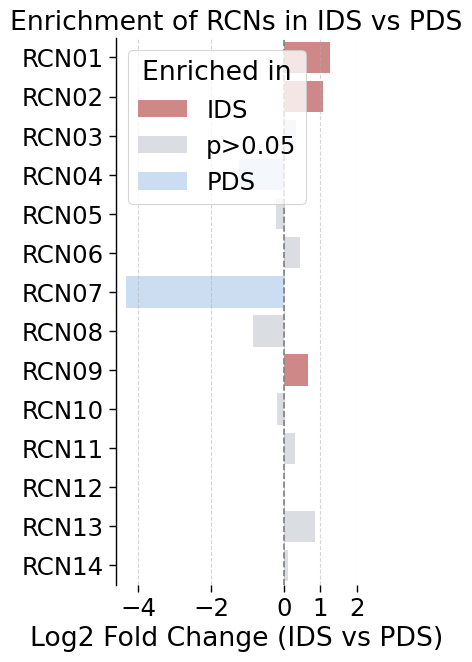

In [8]:
plot_foldchange_inIDSandPDS(df_grouped, "/Volumes/h345/afarkkilab/Projects/NKI/RCN_exploration/FCofRCNmedianproportions_IDCvsPDS.svg")

In [12]:
len(df_grouped['patient'].unique())

223

# Fold change between TSI RCN9 and RCN10

### Remove patients with few cells for TSI RCNs

In [9]:
filtered_patients = []

for rcn in ['RCN09','RCN10']:
    
    rcn_df = filtered_df[filtered_df['rcn_id']==rcn]
    
    counts_df = rcn_df['patient'].value_counts().reset_index()
    counts_df.columns = ['patient', 'count']
    
    # Compute 1st and 99th percentiles
    low_threshold = 100
    high_threshold = counts_df['count'].quantile(0.99)
    
    # Find patients to remove
    patients_to_remove = counts_df[
        (counts_df['count'] < low_threshold) | 
        (counts_df['count'] > high_threshold)
    ]['patient'].tolist()
    
    filtered_patients.extend(patients_to_remove)

# Remove duplicates from the final list
filtered_patients = list(set(filtered_patients))
# print(filtered_patients)

print(f"Original number of patients: {len(filtered_df['patient'].unique())}")
tsi_filtered_df = filtered_df[~filtered_df['patient'].isin(filtered_patients)]
print(f"Filtered number of patients: {len(tsi_filtered_df['patient'].unique())}")


Original number of patients: 223
Filtered number of patients: 180


In [10]:
# Group by patient, rcn_label, and GlobalCellType, then count occurrences
tsi_patient_rcns_counts = (
    tsi_filtered_df
    .groupby(['patient', 'rcn_id', 'GlobalCellType'])
    .size()
    .reset_index(name='count')
)

# Calculate the total counts for each patient and RNC ID combination
total_counts = tsi_patient_rcns_counts.groupby(['patient', 'rcn_id'])['count'].transform('sum')

# Calculate the proportion of each GlobalCellType within the patient and RCN
tsi_patient_rcns_counts['proportion'] = tsi_patient_rcns_counts['count'] / total_counts

# View the resulting dataframe
print(tsi_patient_rcns_counts.head())

     patient rcn_id GlobalCellType  count  proportion
0  T08-03800  RCN01        B.cells     21    0.001261
1  T08-03800  RCN01       CD11c.MY      2    0.000120
2  T08-03800  RCN01        CD15.MY      3    0.000180
3  T08-03800  RCN01       CD163.MP     44    0.002643
4  T08-03800  RCN01       CD207.MY      5    0.000300


### Plot the fold change in proportion across ordered cell types in RCN9 vs RCN10

             CellType  FoldChange  -Log10Pvalue
14            Stromal   -1.804912     51.811441
5        CD31.stromal   -0.106442      0.652884
9           Can.Basal   -0.447564      2.951485
16  Can.Proliferative    0.191002      0.585705
10            Can.EMT    0.827354     22.431399
11    Can.Immunogenic    1.005103     10.821231
8         CD8.T.cells    0.869104      7.493800
6         CD4.T.cells    0.888244      7.427364
15             T.regs    0.740811      9.001368
1            CD11c.MY    1.673322     18.483359
2             CD15.MY    1.521937      8.983897
4            CD207.MY    0.930293      3.813462
13           Other.MY    0.560955      5.927887
3            CD163.MP    0.478851      2.910173
7             CD68.MP    1.003739      5.282053
0             B.cells    1.717627     12.690238
17       Other.immune    2.486367      6.229217
12              Other   -0.079737      0.578839


/var/folders/xc/lk995w7563j66dr15k7gw56h0000gp/T/ipykernel_31388/3116184753.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rcn9to10_df = rcn9to10_df.append({'CellType': celltype, 'FoldChange':np.median(rcn9_values)/np.median(rcn10_values), '-Log10Pvalue': -np.log10(p_value)},
/var/folders/xc/lk995w7563j66dr15k7gw56h0000gp/T/ipykernel_31388/3116184753.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rcn10to9_df = rcn10to9_df.append({'CellType': celltype, 'FoldChange':np.log2(np.median(rcn10_values)/np.median(rcn9_values)), '-Log10Pvalue': -np.log10(p_value)},
/var/folders/xc/lk995w7563j66dr15k7gw56h0000gp/T/ipykernel_31388/3116184753.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rcn9to10_df = rcn9to10_df.app

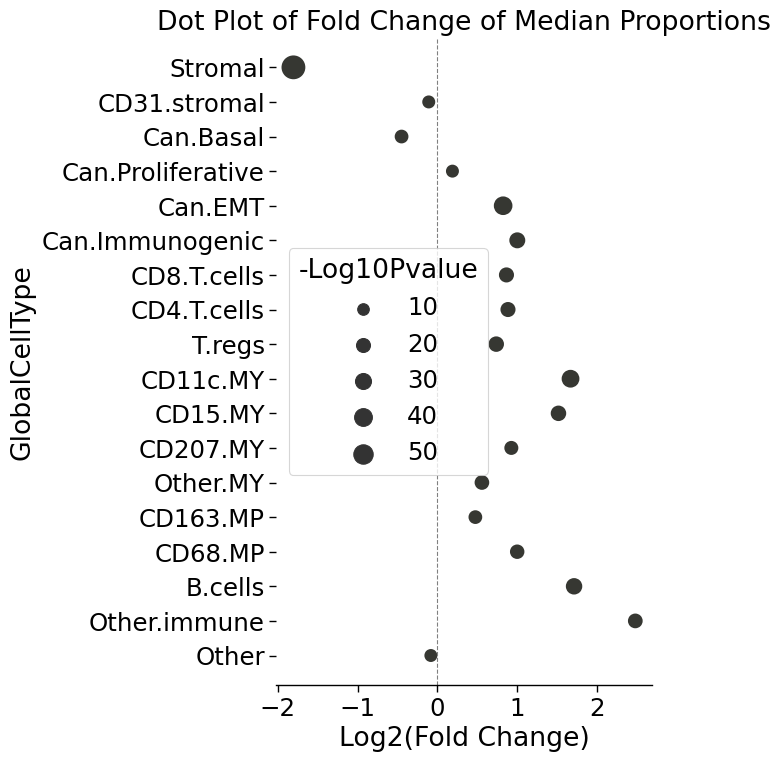

In [11]:
ordered_celltypes = list(celltype_colors.keys())
plot_foldchnage_scatter(tsi_patient_rcns_counts, ordered_celltypes, filename="/Volumes/h345/afarkkilab/Projects/NKI/RCN_exploration/TSI_RCNs_patientcomparison.svg")

In [13]:
len(tsi_patient_rcns_counts['patient'].unique())

180